## TODO

1. Implement perfect statevector simulation, for perfect kernel entries.
2. Implement a measure of peak width W($\gamma$)
3. Implement a measure of average gradient value $\langle G \rangle$
4. Check the W($\gamma$) and $\langle G \rangle$ as a function of shot noise (number of shots)
5. Check the W($\gamma$) and $\langle G \rangle$ as a function of N
6. Check the W($\gamma$) and $\langle G \rangle$ as a function of perturbations of x

## Imports

In [44]:
import pandas as pd
#from pennylane 
import numpy as np
import matplotlib.pyplot as plt

import copy

from qiskit import Aer
from qiskit.algorithms.optimizers import SPSA

from qiskit import QuantumCircuit, assemble
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.circuit import Parameter

from matplotlib.colors import ListedColormap

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [10,5]
plt.rcParams['font.size'] = 20

## Setup

Creating the beads

In [45]:
N = 20
x = np.linspace(0,1,N)
y = (-1)**np.linspace(0,N-1,N)

In [46]:
sim = Aer.get_backend('aer_simulator')

In [47]:
def qubit_map(phi):
    qc = QuantumCircuit(1)
    qc.h(0)
    qc.p(phi, 0)
    qc.h(0)
    return(qc)

In [48]:
def kernel_map():
    x1 = Parameter('x1')
    x2 = Parameter('x2')
    phi = Parameter('Φ')
    qc = QuantumCircuit(1,1)
    qc.h(0)
    qc.p(phi*x1, 0)
    qc.p(-1.0*phi*x2,0)
    qc.h(0)
    qc.measure(0, 0)
    return(x1, x2, phi, qc)

In [49]:
def get_kernel_entry(qc, x1, x1_value, x2, x2_value, phi, phi_value, sim = Aer.get_backend('aer_simulator')): #, x1 = Parameter('x1'), x2 =  Parameter('x2'), phi = Parameter('Φ')
    qc_bound = qc.bind_parameters({x1:float(x1_value), x2:float(x2_value), phi:float(phi_value)})
    qobj = assemble(qc_bound)  # Assemble circuit into a Qobj that can be run
    counts = sim.run(qobj).result().get_counts()  # Do the simulation, returning the state vector
    if(counts.get('0')):
        kernel_element = counts.get('0')/(sum(counts[item] for item in counts))
    else:
        kernel_element = 0
    return(kernel_element)

In [50]:
x1, x2, phi, qc_test = kernel_map()

In [51]:
def get_kernel(x, phi_value):
    x1, x2, phi, qc_out = kernel_map()
    #return(qc_out.draw(output='mpl'))
    kernel = np.zeros((len(x),len(x)))
    for i in range(len(x)):
        for j in range(i):
            x1_value = x[i]
            x2_value = x[j]
            #print("x1: ", x1_value, "x2: ", x2_value)
            kernel[i,j] = get_kernel_entry(qc= qc_out, x1= x1, x1_value= x1_value, x2= x2, x2_value= x2_value, phi= phi, phi_value = phi_value)
    kernel = kernel+np.transpose(kernel) + np.identity(len(x))
    return(kernel)

In [52]:
def matrix_target_alignment(K, Y, rescale_class_labels=True):
    if rescale_class_labels:
        nplus = np.count_nonzero(np.array(Y) == 1)
        nminus = len(Y) - nplus
        _Y = np.array([y / nplus if y == 1 else y / nminus for y in Y])
    else:
        _Y = np.array(Y)

    #####
    labels = _Y.copy()
    classes = np.unique(labels)
    centered_labels = (labels - classes.mean())
    _Y = np.array(centered_labels/centered_labels.max())
    #####

    T = np.outer(_Y, _Y)
    inner_product = np.sum(K * T)
    norm = np.sqrt(np.sum(K * K) * np.sum(T * T))
    inner_product = inner_product / norm

    return inner_product

Target kernel alignment landscape

In [53]:
def loss(phi_val):
    return( - matrix_target_alignment(get_kernel(x, phi_val), y))

In [54]:
startpoint = 0
endpoint = 2*np.pi*(N-1)
points_number = 150
param_test = np.linspace(startpoint,endpoint, points_number)

In [55]:
Target_a = []
for item in param_test:
    Target_a.append(-loss(item))

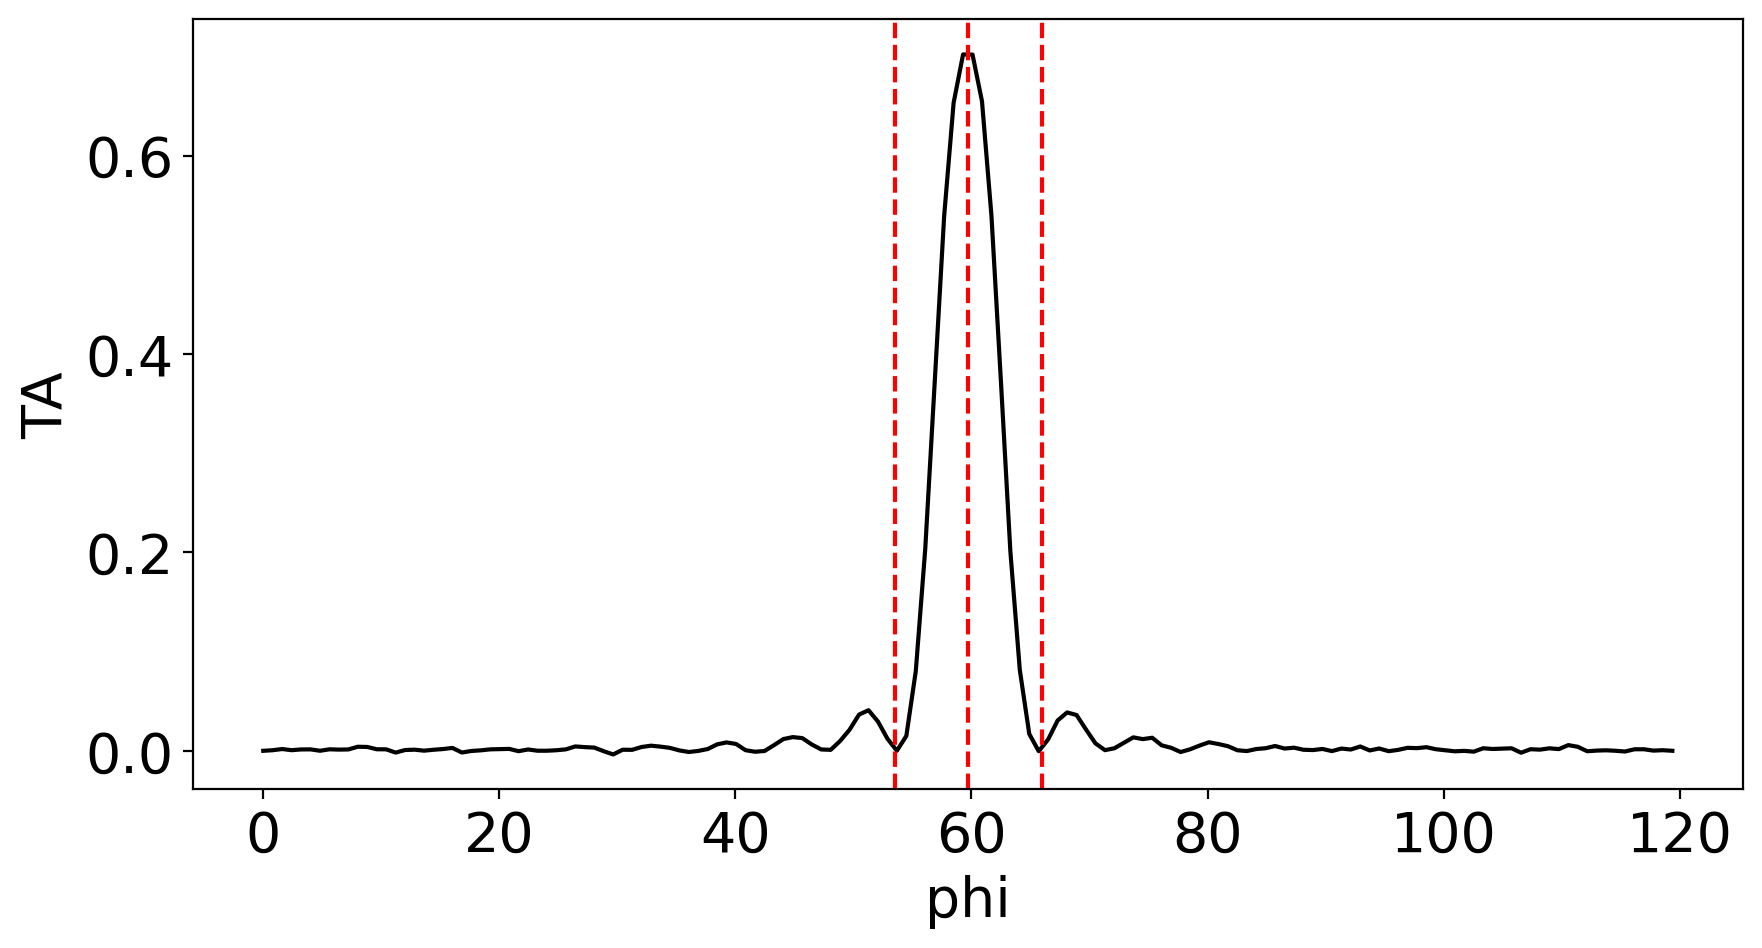

In [61]:
plt.plot(param_test, Target_a, c="k")
plt.xlabel("phi")
plt.ylabel("TA")
plt.axvline(x=np.pi*(N-1), c='red', linestyle='--')
plt.axvline(x=53.5, c='red', linestyle='--')
plt.axvline(x=66, c='red', linestyle='--')
plt.show()

In [43]:
(34-22.5)/(2*np.pi*(N-1))

0.20336464950631072

In [62]:
(66-53.5)/(2*np.pi*(N-1))

0.10470719940256273